# Notebook to try reading SMAP satellite salinity data

https://podaac.jpl.nasa.gov/dataset/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5

Bucket/Object Prefix:  
podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/

Short Name:
SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5  
Collection Concept ID:
C2208425700-POCLOUD



In [1]:
#Pretty sure some of these are extraneous
import s3fs
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import sys
sys.path.append('../src')
import functions

'''
import os
import os.path
import json
import warnings

rom io import StringIO


import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

warnings.filterwarnings("ignore")
'''

# %matplotlib inline
# %matplotlib qt5
%matplotlib widget

## Set some parameters (start/end time)

In [2]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 400

savefig = True # set to true to save plots as file
!mkdir ../plots

__figdir__ = '../plots/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

mkdir: cannot create directory ‘../plots’: File exists


### Loading credentials for direct access

In [3]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [4]:
# Center location
#site = 'S-MODE'
site = 'S-MODE IOP2'
#site = 'SPURS-1'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP1':
    lon0 = -124
    lat0 = 37.5
    dlon = 3.0 # half of box width in lon
    dlat = 3.0 # half of box width in lat
elif site == 'S-MODE IOP2':
    lon0 = -124
    lat0 = 37.5
    dlon = 3.0 # half of box width in lon
    dlat = 3.0 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [5]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-06T00:00:00Z'
elif site == 'S-MODE IOP1':
    start_time = '2022-10-01T00:00:00Z'#
    end_time = '2022-11-06T00:00:00Z'
elif site == 'S-MODE IOP2':
    start_time = '2023-03-16T00:00:00Z'#
    end_time = '2023-05-06T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2017-1-05T00:00:00Z'#'2016-8-20T00:00:00Z'
    end_time = '2017-11-06T00:00:00Z'
elif site == 'SPURS-1':
    start_time = '2012-12-15T00:00:00Z'#'2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'



Short Name:
SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5  
Collection Concept ID:
C2208425700-POCLOUD


In [6]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

#concept_id = 'C2208425700-POCLOUD'; shortname= 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5'
concept_id = 'C2208425700-POCLOUD'; shortname= 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
23


In [7]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][0]['href'])
# granules_url
len(granules_url)
print('Number of files found is ' + str(len(granules_url)))
if len(granules_url) == 500:
    print('Max number of files returned. There may be more files.  Try shortening time window.')

Number of files found is 23


In [8]:
gran['links'];#['rel'=='http://esipfed.org/ns/fedsearch/1.1/s3#'];

## There is an inconvenient issue with these files.  The correct link is not in the same place for each of the granules

This was an attempt to fix the issue by just dropping the md5 suffix.  That almost works, but the prefix should be something like:  
s3://podaac-ops-cumulus-protected/ 

and not:  
s3://podaac-ops-cumulus-public/

In [9]:
granules_url2 = []
for gran in granules_url:
    #print(gran.replace('.md5',''))
    gran2 = gran.replace('.md5','')
    #print(gran2[gran2.index('/VIIRS'):])
    granules_url2.append('s3://podaac-ops-cumulus-protected'+gran2[gran2.index('/SMAP_RSS'):])


In [10]:
granules_url2;

In [11]:
ds = xr.open_dataset(fs.open(granules_url2[1]))

In [12]:
ds

<xarray.Dataset>
Dimensions:                 (lon: 1440, lat: 720, time: 1,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
  * lat                     (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                    (time) datetime64[ns] 2023-03-13T12:00:00
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (lat, lon) float64 ...
    nobs_RF                 (lat, lon) float64 ...
    nobs_40km               (lat, lon) float64 ...
    sss_smap                (lat, lon) float32 ...
    sss_smap_RF             (lat, lon) float32 ...
    sss_smap_unc            (lat, lon) float32 ...
    ...                      ...
    fland                   (lat, lon) float32 ...
    gice_est                (lat, lon) float32 ...
    surtep                  (lat, lon) float32 ...
    winspd                  (lat, lon) float32 ...
    sea_ice_zones           (lat, lon) int8 ...
    anc_sea_ice_flag        (lat, lon, iceflag_components) int8 ...
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [13]:
file_list =  [fs.open(file) for file in granules_url2]

In [14]:
lon_min2=lon_min+360
lon_max2=lon_max+360

In [15]:
ds = xr.open_mfdataset(file_list).sel(lon=slice(lon_min2,lon_max2), lat=slice(lat_min,lat_max))

In [16]:
ds

<xarray.Dataset>
Dimensions:                 (lon: 24, lat: 24, time: 23,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 233.1 233.4 233.6 ... 238.6 238.9
  * lat                     (lat) float32 34.62 34.88 35.12 ... 40.12 40.38
  * time                    (time) datetime64[ns] 2023-03-12T12:00:00 ... 202...
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (time, lat, lon) float64 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    nobs_RF                 (time, lat, lon) float64 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    sss_smap                (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    sss_smap_RF             (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    ...                      ...
    fland                   (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    gice_est                (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    surtep                  (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    winspd                  (time, lat, lon) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    sea_ice_zones           (time, lat, lon) int8 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) int8 dask.array<chunksize=(1, 24, 24, 3), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [17]:
ds2 = ds.isel(time=-1)
# This string of the time of the SST selected will be useful
day_str = np.datetime_as_string(ds2.time,unit='m')

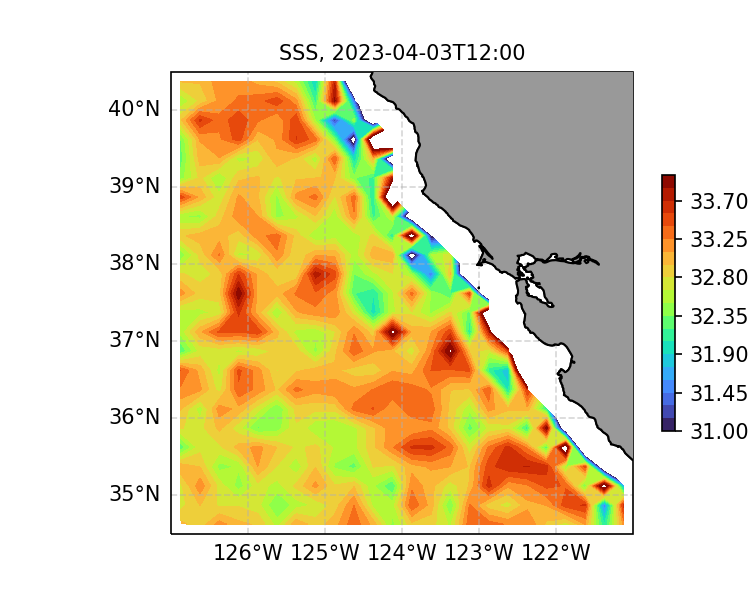

In [18]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SSS, ' + day_str, size = 10.)

# Does not do what I think it should:
ax.minorticks_on()
ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)

V=np.linspace(31,34,num=21)

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
#cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sss_smap_40km.squeeze(),vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
cs = ax.contourf(ds2.lon,ds2.lat,ds2.sss_smap_40km.squeeze(),levels=V,transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SST [$\circ$C]',fontsize = 10)


# Export figure
if savefig:
    plt.savefig(__figdir__+'SMAP_map_40km_' + shortname + '.' +plotfiletype,**savefig_args)

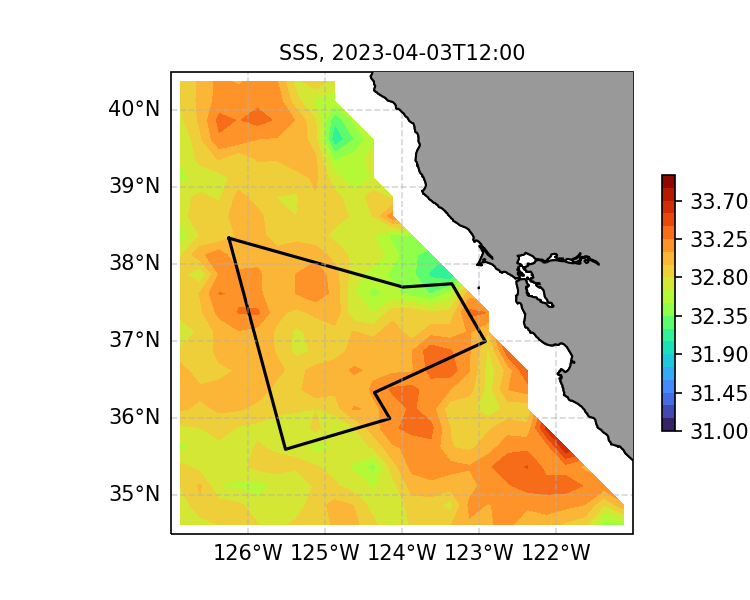

In [19]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SSS, ' + day_str, size = 10.)

# Does not do what I think it should:
ax.minorticks_on()
ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)

V=np.linspace(31,34,num=21)

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
#cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sss_smap_40km.squeeze(),vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
cs = ax.contourf(ds2.lon,ds2.lat,ds2.sss_smap.squeeze(),levels=V,transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SST [$\circ$C]',fontsize = 10)
functions.plot_ops_area_IOP2(ax,transform=ccrs.PlateCarree(),color='k')


# Export figure
if savefig:
    plt.savefig(__figdir__+'SMAP_map_' + shortname + '.' +plotfiletype,**savefig_args)

In [20]:
# Write the subsetted data set to a netcdf file
#ds2.to_netcdf('../data/processed/sss_outfile.nc',format="NETCDF4")

In [21]:
def plot_sss(ax,V):
    extent = [lon_min, lon_max,lat_min, lat_max]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    plt.set_cmap(cmap=plt.get_cmap('turbo'))
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title('SSS, ' + day_str, size = 10.)

    # Does not do what I think it should:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
    #cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sss_smap_40km.squeeze(),vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
    cs = ax.contourf(ds2.lon,ds2.lat,ds2.sss_smap.squeeze(),levels=V,transform=ccrs.PlateCarree())
    # cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
    cb = plt.colorbar(cs,fraction = 0.022,extend='both')
    cb.set_label('SSS',fontsize = 10)

In [22]:
#Clear contents of movie folder
import glob, os
for f in glob.glob(__figdir__+'SMAP_movie/*.*'):
    os.remove(f)


FileNotFoundError: [Errno 2] No such file or directory: '../plots/SMAP_movie/SMAP_map_01-SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5.png'

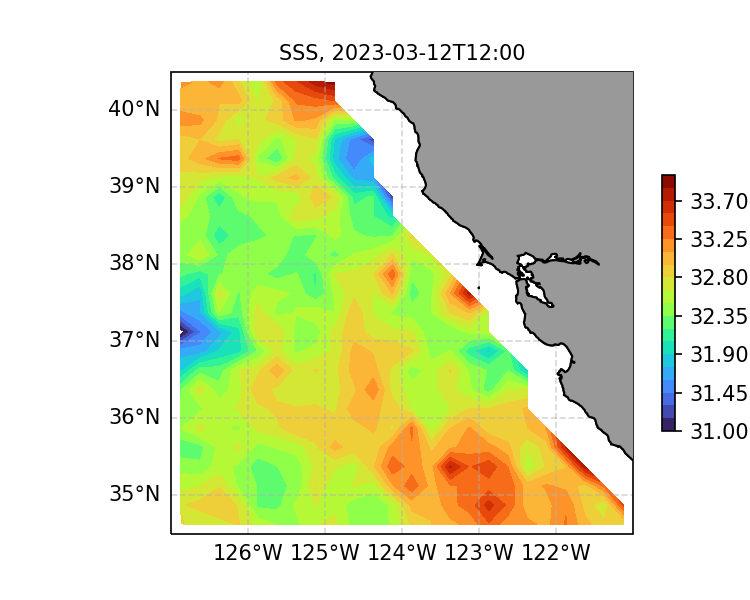

In [23]:

fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
V = np.linspace(31,34,num=21)
count=0;
for t in ds.time:
    count=count+1
    count_str="%02d" % count
    ds2 = ds.sel(time=t)
    # This string of the time of the SST selected will be useful
    day_str = np.datetime_as_string(ds2.time,unit='m')
    
    plt.clf()
    ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
    plot_sss(ax,V)
    # Export figure
    if savefig:
        plt.savefig(__figdir__+'SMAP_movie/SMAP_map_' +count_str +'-' + shortname + '.' +plotfiletype,**savefig_args)
    

In [ ]:
ds.time[0:2]

In [ ]:
plot_names = __figdir__+'SMAP_movie/SMAP_map_%2d-SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5.png'
movie_name = __figdir__ + 'test_movie.avi'

In [ ]:
!ffmpeg -y -framerate 3 -i $plot_names $movie_name